In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show, ion
import matplotlib.image as mpimg
import cv2
import scipy.io
from tqdm import tqdm

# from scipy.stats import ortho_group
import os
import sys
sys.path.append("../../src")
sys.path.append("../../data")

from NSMBSS import *
from ICA import fit_icainfomax
from general_utils import *
from visualization_utils import * 
from numba import njit
import warnings

warnings.filterwarnings("ignore")
np.random.seed(250)

In [2]:
image_paths = '../../data/TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [3]:
small_images = np.zeros((images.shape[0],324* 432* 3))
small_to_large_image_size_ratio = 0.1
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    if small_img.shape[0] == 302:
        small_img = cv2.resize(small_img, (0,0), fx = 432/403, fy = 324/302)
    print(small_img.shape)
    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)


(4, 419904)

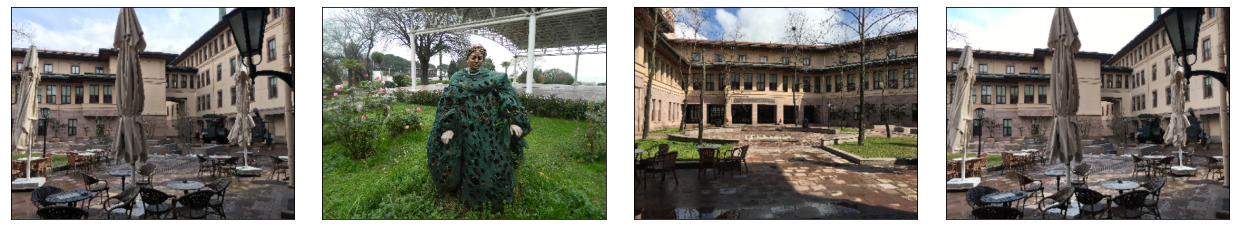

In [4]:
Subplot_RGB_images(small_images, imsize = [324,432], height = 4, width = 18)

<IPython.core.display.Math object>

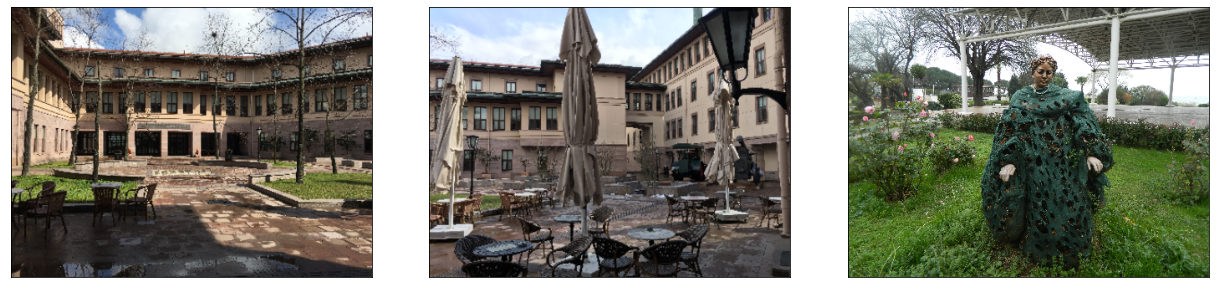

In [5]:
S = small_images[[2,0,1]]
Subplot_RGB_images(S, imsize = [324,432], height = 4, width = 18)
display_matrix(np.corrcoef(S))
# plt.savefig('Original_Images.pdf', format = 'pdf', dpi = 1500)

In [6]:
np.random.seed(50)
NumberofMixtures = 5
NumberofSources = 3

INPUT_STD = 0.28

A, Xn = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)

SNR=40
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNR/20)*INPUT_STD
X=Xn+Noisecomp

print('Input SNR : {}'.format(20*np.log10(np.std(Xn)/np.std(Noisecomp))))

X_ = ZeroOneNormalizeColumns(X.T).T
print('The following is the mixture matrix')
display_matrix(A)

Input SNR : 41.122659361820595
The following is the mixture matrix


<IPython.core.display.Math object>

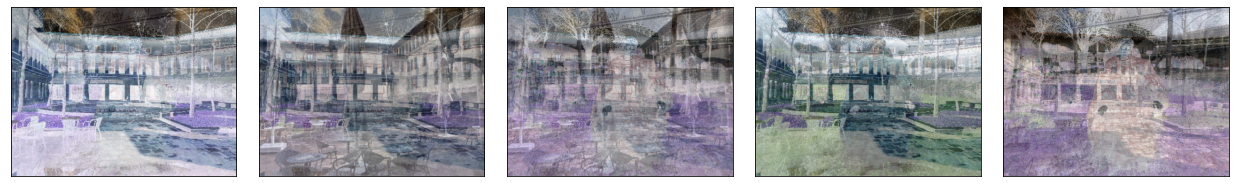

In [7]:
Subplot_RGB_images(X_, imsize = [324,432], height = 3, width = 18)
# plt.savefig('Mixture_Images.pdf', format = 'pdf', dpi = 1500)

In [8]:
model = OnlineNSM(s_dim = NumberofSources, x_dim = NumberofMixtures, set_ground_truth = True, S = S, A = A)

In [9]:
model.fit_batch_nsm(X = X, debug_iteration_point = 50000, plot_in_jupyter = False)

100%|██████████| 419904/419904 [03:03<00:00, 2293.64it/s]


In [10]:
Wf = model.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [16.47973675 18.46087958 14.70825929]

Overall SINR : 17.789273759548752


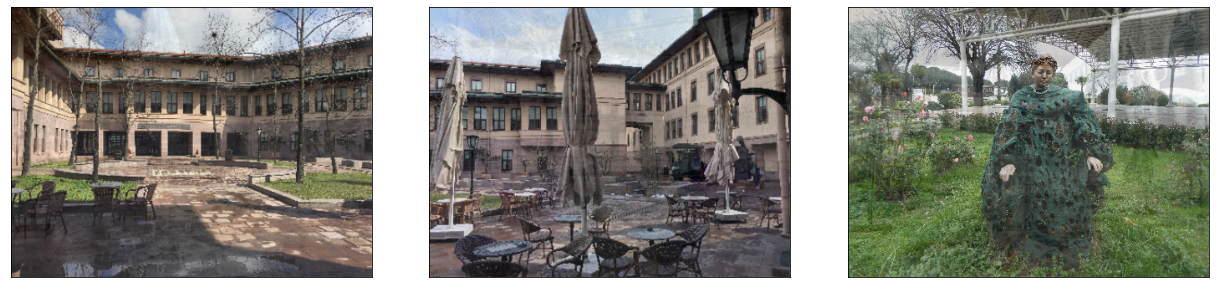

In [11]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y_.T).T, imsize = [324,432], height = 4, width = 18)

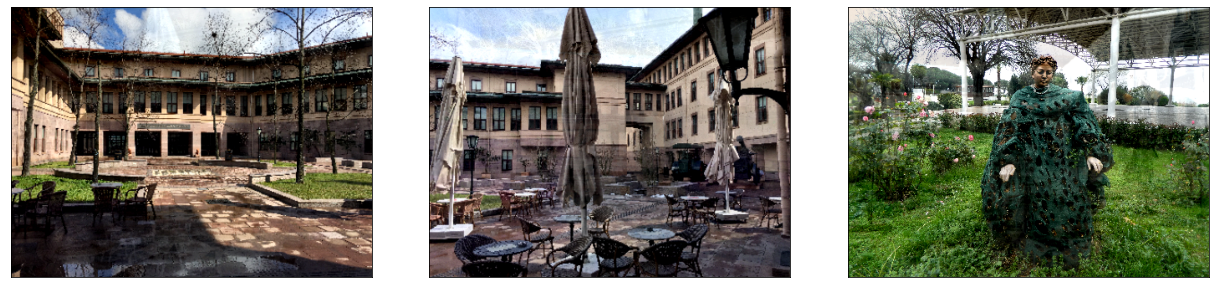

In [12]:
Subplot_RGB_images(np.clip(Y_, 0,1), imsize = [324,432], height = 4, width = 18)